# Homework 3

In [2]:
# import necessary packages
import pandas as pd
from pandas import read_csv
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import Perceptron
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.filterwarnings("ignore")

# reading csv data file
df = read_csv("AMZN.csv")
dfSonar = read_csv("sonar.all-data.csv")

# data prep
adjClose = df[['Adj Close']].values
arraySonar = dfSonar.values
dataSonar = arraySonar[:,:-1]
targetSonar = arraySonar[:,-1]

In [3]:
# series_to_supervised function
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
  

## Problem 1

### (a)

In [4]:
# create supervised learning set from closing data
supervisedDF = series_to_supervised(adjClose, 10)
print(supervisedDF)

       var1(t-10)    var1(t-9)    var1(t-8)    var1(t-7)    var1(t-6)  \
10       1.958333     1.729167     1.708333     1.635417     1.427083   
11       1.729167     1.708333     1.635417     1.427083     1.395833   
12       1.708333     1.635417     1.427083     1.395833     1.500000   
13       1.635417     1.427083     1.395833     1.500000     1.583333   
14       1.427083     1.395833     1.500000     1.583333     1.531250   
...           ...          ...          ...          ...          ...   
5753  1676.609985  1785.000000  1689.150024  1807.839966  1830.000000   
5754  1785.000000  1689.150024  1807.839966  1830.000000  1880.930054   
5755  1689.150024  1807.839966  1830.000000  1880.930054  1846.089966   
5756  1807.839966  1830.000000  1880.930054  1846.089966  1902.829956   
5757  1830.000000  1880.930054  1846.089966  1902.829956  1940.099976   

        var1(t-5)    var1(t-4)    var1(t-3)    var1(t-2)    var1(t-1)  \
10       1.395833     1.500000     1.583333     1.

## (b)

In [5]:
# df to array and scaling
array = supervisedDF.values
scaler = MinMaxScaler()
array = scaler.fit_transform(array)

### (c)

In [6]:
# splitting data set
data = array[:,0:10]
target = array[:,10]

# Adding bias and reshaping
shape = data.shape[0]
data = np.append(np.ones((shape,1)), data, axis=1)
target = target.reshape(shape,1)

# Normal Equation
theta = np.dot(np.linalg.inv(np.dot(data.T,data)), np.dot(data.T,target))

# train test split
X_Train, X_Test, Y_Train, Y_Test = train_test_split(data, target, train_size = 0.7, random_state=1)

### (d)

In [7]:
# prediction with MSE & R2
prediction = np.dot(X_Test, theta)
print("MSE: %.3f" % mean_squared_error(Y_Test, prediction))
print("R2: %.3f" % r2_score(Y_Test, prediction))

MSE: 0.000
R2: 1.000


### (e)

In [8]:
# functions for gradient descent
def predict(row, coefficients):
    prediction = coefficients[0]
    for i in range (len(row)):
        prediction = prediction + coefficients[i+1] * row[i]
    return prediction

def coefficients_sgd(X_Train, Y_Train, learning_rate, iterations):
    coef = [0.0 for i in range(len(X_Train[0])+1)]

    for epoch in range(iterations):
        sum_error = 0
        for i in range(X_Train.shape[0]):
            gradientPrediction = predict(X_Train[i,:], coef)
            error = gradientPrediction - Y_Train[i]
            sum_error += error**2
            coef[0] = coef[0] - learning_rate * error
            for j in range(len(coef)-1):
                coef[j+1] = coef[j+1] - learning_rate * error * X_Train[i,j]
        print( ' >epoch=%d, lrate=%.3f, error=%.3f ' % (epoch, learning_rate, sum_error))
    return coef

### (f)

In [9]:
# apply functions and predict
learning_rate = 0.01
iterations = 200
coef = coefficients_sgd(X_Train, Y_Train, learning_rate, iterations)

Y_Prediction = np.array(predict(X_Test[0,:], coef))
for i in range (X_Test.shape[0]-1):
    Y_Prediction = np.append(Y_Prediction, predict(X_Test[i+1,:], coef))
    
print("MSE: %.3f" % mean_squared_error(Y_Test, Y_Prediction))
print("R2: %.3f" % r2_score(Y_Test, Y_Prediction))

 >epoch=0, lrate=0.010, error=5.694 
 >epoch=1, lrate=0.010, error=0.455 
 >epoch=2, lrate=0.010, error=0.450 
 >epoch=3, lrate=0.010, error=0.444 
 >epoch=4, lrate=0.010, error=0.439 
 >epoch=5, lrate=0.010, error=0.434 
 >epoch=6, lrate=0.010, error=0.429 
 >epoch=7, lrate=0.010, error=0.424 
 >epoch=8, lrate=0.010, error=0.419 
 >epoch=9, lrate=0.010, error=0.415 
 >epoch=10, lrate=0.010, error=0.410 
 >epoch=11, lrate=0.010, error=0.406 
 >epoch=12, lrate=0.010, error=0.401 
 >epoch=13, lrate=0.010, error=0.397 
 >epoch=14, lrate=0.010, error=0.393 
 >epoch=15, lrate=0.010, error=0.389 
 >epoch=16, lrate=0.010, error=0.385 
 >epoch=17, lrate=0.010, error=0.381 
 >epoch=18, lrate=0.010, error=0.377 
 >epoch=19, lrate=0.010, error=0.373 
 >epoch=20, lrate=0.010, error=0.369 
 >epoch=21, lrate=0.010, error=0.365 
 >epoch=22, lrate=0.010, error=0.362 
 >epoch=23, lrate=0.010, error=0.358 
 >epoch=24, lrate=0.010, error=0.355 
 >epoch=25, lrate=0.010, error=0.352 
 >epoch=26, lrate=0.01

## Problem 2

In [9]:
# train test split
XTrain, XTest, YTrain, YTest = train_test_split(dataSonar, targetSonar, test_size = 0.3, random_state=3)

# Perceptron model w/ RepeatedStratifiedKFold
model = Perceptron()
model.fit(XTrain,YTrain)
repStratKFold = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)

# creating grid and applying on Perceptron
grid = dict()
grid["alpha"] = [0.0001, 0.001, 0.01, 0.1]
gridSearch = GridSearchCV(model, grid, scoring="accuracy",cv=repStratKFold, n_jobs=1)

# reporting score
results = gridSearch.fit(XTrain,YTrain)
print('Mean Accuracy: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

# Perceptron model with best value
bestModel = Perceptron(alpha=0.0001)
bestModel.fit(XTrain,YTrain)
bestPrediction = bestModel.predict(XTest)
print('Accuracy of Perceptron Model w/ best alpha: %3f' % accuracy_score(YTest,bestPrediction))

Mean Accuracy: 0.664
Config: {'alpha': 0.0001}
Accuracy of Perceptron Model w/ best alpha: 0.650794


## Problem 3

### (a)

In [10]:
# train test split
XTrain, XTest, YTrain, YTest = train_test_split(dataSonar, targetSonar, test_size = 0.3, random_state=5)

# KNN model
kResults = {}
for k in range(1,31):
    kNeighbors = KNeighborsClassifier(n_neighbors=k)
    kNeighbors.fit(XTrain,YTrain)
    kPrediction = kNeighbors.predict(XTest)
    kResults[k] = accuracy_score(kPrediction,YTest)
kResults

{1: 0.7777777777777778,
 2: 0.7142857142857143,
 3: 0.7301587301587301,
 4: 0.7142857142857143,
 5: 0.746031746031746,
 6: 0.746031746031746,
 7: 0.6507936507936508,
 8: 0.6349206349206349,
 9: 0.6666666666666666,
 10: 0.6666666666666666,
 11: 0.6825396825396826,
 12: 0.6507936507936508,
 13: 0.6666666666666666,
 14: 0.6507936507936508,
 15: 0.6825396825396826,
 16: 0.6666666666666666,
 17: 0.6507936507936508,
 18: 0.6666666666666666,
 19: 0.6507936507936508,
 20: 0.7142857142857143,
 21: 0.6825396825396826,
 22: 0.6825396825396826,
 23: 0.6984126984126984,
 24: 0.6825396825396826,
 25: 0.6825396825396826,
 26: 0.6825396825396826,
 27: 0.6666666666666666,
 28: 0.6984126984126984,
 29: 0.7142857142857143,
 30: 0.6984126984126984}

### (b)

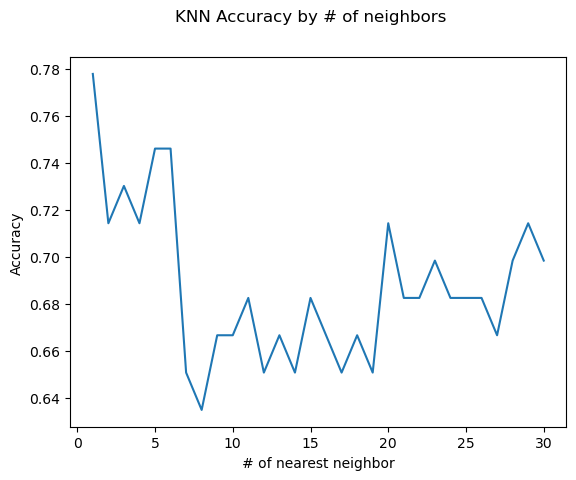

In [11]:
# plotting KNN model
plt.plot(list(kResults.keys()),list(kResults.values()))
plt.suptitle('KNN Accuracy by # of neighbors')
plt.xlabel('# of nearest neighbor')
plt.ylabel('Accuracy')
plt.show()

### (c)

In [12]:
## KNN model using best value
kBest = KNeighborsClassifier(n_neighbors=1)
kBest.fit(XTrain,YTrain)
kBestPrediction = bestModel.predict(XTest)
print('Accuracy of KNN Model w/ best # of neighbors: %3f' % accuracy_score(YTest,kBestPrediction))

Accuracy of KNN Model w/ best # of neighbors: 0.682540
